# 建立对话机器人

实现历史对话方法1 直接传messages的方法

In [1]:
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage

llm = ChatOpenAI(
    base_url="http://localhost:8000/v1",
    api_key="empty",
    model="Qwen/Qwen2.5-7B-Instruct"
)
print(llm.invoke([
    HumanMessage("my name is bob"),
    AIMessage("Hello Bob! How can I assist you today?"),
    HumanMessage("what's my name?")
]).content)

Your name is Bob.


实现历史对话方法2 使用langgraph

为了能够看懂教程的langgraph内容 去看一下langgraph的教程

In [2]:
import requests
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import START, StateGraph, END
from langgraph.graph.message import add_messages

In [3]:
model_name = requests.get("http://localhost:8000/v1/models").json()["data"][0]["id"]
print(model_name)

Qwen/Qwen2.5-7B-Instruct


In [4]:
llm = ChatOpenAI(
    base_url="http://localhost:8000/v1",
    api_key="empty",
    model=model_name
)
llm.invoke("你好")

AIMessage(content='你好！很高兴见到你。有什么问题或者需要帮助的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 30, 'total_tokens': 45, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen2.5-7B-Instruct', 'system_fingerprint': None, 'id': 'chatcmpl-221cd7f36e0844ceb277fa3934c2e974', 'finish_reason': 'stop', 'logprobs': None}, id='run-9b7c3b2e-aa48-4c37-b740-d49134f0c47b-0', usage_metadata={'input_tokens': 30, 'output_tokens': 15, 'total_tokens': 45, 'input_token_details': {}, 'output_token_details': {}})

In [5]:
class State(TypedDict):
    # 这里用pydantic应该也可以
    messages: Annotated[list, add_messages]

def chat_node(state:State):
    print(state)
    return {"messages": [llm.invoke(state["messages"])]}

def should_continue(state:State):
    
    if state["messages"][-1] == "exit" or len(state)>5:
        return "end"
    else:
        return "continue"
    

graph_builder = StateGraph(State)
# 节点就是开始 对话 结束  并不能支持多轮对话
graph_builder.add_node("chat_node", chat_node)
graph_builder.add_edge(START, "chat_node")
graph_builder.add_edge("chat_node", END)

graph = graph_builder.compile()

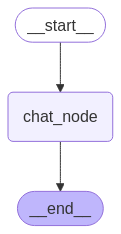

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({"messages": {"role": "user", "content": "my name is bob"}})

{'messages': [HumanMessage(content='my name is bob', additional_kwargs={}, response_metadata={}, id='077c59c9-f2a6-46db-8293-3def023a06e2')]}


{'messages': [HumanMessage(content='my name is bob', additional_kwargs={}, response_metadata={}, id='077c59c9-f2a6-46db-8293-3def023a06e2'),
  AIMessage(content='Hello Bob! Nice to meet you. How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 33, 'total_tokens': 49, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen2.5-7B-Instruct', 'system_fingerprint': None, 'id': 'chatcmpl-2963bdf7f303431ab09badcf1d430f85', 'finish_reason': 'stop', 'logprobs': None}, id='run-3d56387c-768c-42d1-a3a3-c014468d69b3-0', usage_metadata={'input_tokens': 33, 'output_tokens': 16, 'total_tokens': 49, 'input_token_details': {}, 'output_token_details': {}})]}

这里简单开始使用langgraph来实现多轮对话

In [8]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, StateGraph, END, MessagesState

In [9]:
graph_builder = StateGraph(MessagesState)  # 内置的message state 跟上面是一样的

def chat_node(state:State):
    print(state)
    return {"messages": llm.invoke(state["messages"])}

# 节点就是开始 对话 结束  并不能支持多轮对话
graph_builder.add_node("chat_node", chat_node)
graph_builder.add_edge(START, "chat_node")
graph_builder.add_edge("chat_node", END)

graph = graph_builder.compile(checkpointer=MemorySaver())

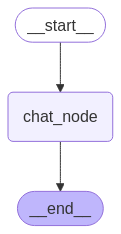

In [10]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
# Checkpointer requires one or more of the following 'configurable' keys: ['thread_id', 'checkpoint_ns', 'checkpoint_id']

config = {
    "configurable": {
        "thread_id": "1",
        # "checkpoint_id": "1"
    }
}
response = graph.invoke({"messages": "my name is bob"}, config=config)
response["messages"][-1].content

{'messages': [HumanMessage(content='my name is bob', additional_kwargs={}, response_metadata={}, id='de722ef6-6d45-4af8-9443-50636f3c6b23')]}


'Hello Bob! Nice to meet you. How can I assist you today?'

In [12]:
response = graph.invoke({"messages": "what's my name"}, config=config)
response["messages"][-1].content

{'messages': [HumanMessage(content='my name is bob', additional_kwargs={}, response_metadata={}, id='de722ef6-6d45-4af8-9443-50636f3c6b23'), AIMessage(content='Hello Bob! Nice to meet you. How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 33, 'total_tokens': 49, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen2.5-7B-Instruct', 'system_fingerprint': None, 'id': 'chatcmpl-6d1b1b38f365488ebfcf17623d6004f7', 'finish_reason': 'stop', 'logprobs': None}, id='run-69e8b000-b970-45ff-bb40-78a2adb79b9e-0', usage_metadata={'input_tokens': 33, 'output_tokens': 16, 'total_tokens': 49, 'input_token_details': {}, 'output_token_details': {}}), HumanMessage(content="what's my name", additional_kwargs={}, response_metadata={}, id='736eb5a3-28a1-4e82-afa7-cebdb325b807')]}


'Your name is Bob!'

In [13]:
config = {
    "configurable": {
        "thread_id": "2",
        # "checkpoint_id": "1"
    }
}

response = graph.invoke({"messages": "what's my name"}, config=config)
response["messages"][-1].content

{'messages': [HumanMessage(content="what's my name", additional_kwargs={}, response_metadata={}, id='bbecb5ae-fe5b-4b5c-9515-828c82793f42')]}


"You didn't provide your name in your question. If you'd like to know your name, please tell me what it is!"

langgraph 使用prompt template

In [14]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [16]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "请你在生成的答案前面增加喵喵喵"),
        MessagesPlaceholder(variable_name="first_message")  # 这里变量就是说跟提示词里替换一样的  这里记一个变量 然后到时候传这个变量来代替他
    ]
)

prompt_template.invoke({"first_message": ["human", "你是谁"]})

ChatPromptValue(messages=[SystemMessage(content='请你在生成的答案前面增加喵喵喵', additional_kwargs={}, response_metadata={}), HumanMessage(content='human', additional_kwargs={}, response_metadata={}), HumanMessage(content='你是谁', additional_kwargs={}, response_metadata={})])

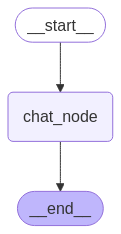

In [30]:
graph_builder = StateGraph(MessagesState)

def chat_node(state:MessagesState):
    prompt = prompt_template.invoke({"first_message": [state["messages"][-1]]})
    return MessagesState({"messages": llm.invoke(prompt)})

graph_builder.add_node("chat_node", chat_node)
graph_builder.add_edge(START, "chat_node")
graph_builder.add_edge("chat_node", END)

graph = graph_builder.compile(checkpointer=MemorySaver())
Image(graph.get_graph().draw_mermaid_png())

In [31]:
config = {
    "configurable": {
        "thread_id": "a"
    }
}
graph.invoke({"messages": "who are you?"},config=config)

{'messages': [HumanMessage(content='who are you?', additional_kwargs={}, response_metadata={}, id='41c86d60-7363-4afb-88bb-2edf27992814'),
  AIMessage(content='喵喵喵，我是来自阿里云的大规模语言模型，我叫通义千问。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 26, 'total_tokens': 47, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen2.5-7B-Instruct', 'system_fingerprint': None, 'id': 'chatcmpl-8ad71f883c8c41fd9fb99ca3c5aa42b0', 'finish_reason': 'stop', 'logprobs': None}, id='run-03a6a509-034c-4eab-8186-972b1a683dcd-0', usage_metadata={'input_tokens': 26, 'output_tokens': 21, 'total_tokens': 47, 'input_token_details': {}, 'output_token_details': {}})]}

In [32]:
graph.invoke({"messages": "你能做什么"},config=config)

{'messages': [HumanMessage(content='who are you?', additional_kwargs={}, response_metadata={}, id='41c86d60-7363-4afb-88bb-2edf27992814'),
  AIMessage(content='喵喵喵，我是来自阿里云的大规模语言模型，我叫通义千问。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 26, 'total_tokens': 47, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen2.5-7B-Instruct', 'system_fingerprint': None, 'id': 'chatcmpl-8ad71f883c8c41fd9fb99ca3c5aa42b0', 'finish_reason': 'stop', 'logprobs': None}, id='run-03a6a509-034c-4eab-8186-972b1a683dcd-0', usage_metadata={'input_tokens': 26, 'output_tokens': 21, 'total_tokens': 47, 'input_token_details': {}, 'output_token_details': {}}),
  HumanMessage(content='你能做什么', additional_kwargs={}, response_metadata={}, id='782e3bb6-a841-42ae-b130-b199d56e043f'),
  AIMessage(content='喵喵喵，我可以帮你查询信息、设置提醒、讲故事或者解答问题哦。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion

In [49]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", "请你在生成的答案前面增加{prefix}"),
        MessagesPlaceholder(variable_name="messages")  # 这里变量就是说跟提示词里替换一样的  这里记一个变量 然后到时候传这个变量来代替他
    ]
)

prompt_template.invoke({"messages": ["human", "你是谁"], "prefix": "喵喵喵"})

ChatPromptValue(messages=[SystemMessage(content='请你在生成的答案前面增加喵喵喵', additional_kwargs={}, response_metadata={}), HumanMessage(content='human', additional_kwargs={}, response_metadata={}), HumanMessage(content='你是谁', additional_kwargs={}, response_metadata={})])

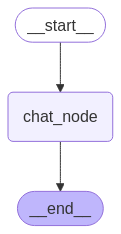

In [50]:
class MyMessageState(TypedDict):
    messages: Annotated[list, add_messages]
    prefix: str

graph_builder = StateGraph(MyMessageState)



def chat_node(state:MyMessageState):
    prompt = prompt_template.invoke(state)
    return MyMessageState({"messages": llm.invoke(prompt)})

graph_builder.add_node("chat_node", chat_node)
graph_builder.add_edge(START, "chat_node")
graph_builder.add_edge("chat_node", END)

graph = graph_builder.compile(checkpointer=MemorySaver())
Image(graph.get_graph().draw_mermaid_png())

In [51]:
config = {
    "configurable": {
        "thread_id": "a"
    }
}
graph.invoke({"messages": "你是谁", "prefix": "喵喵喵"}, config=config)

{'messages': [HumanMessage(content='你是谁', additional_kwargs={}, response_metadata={}, id='18bd171e-cd69-4775-9ac5-9cb13db53f95'),
  AIMessage(content='喵喵喵，我是来自阿里云的超大规模语言模型，我叫通义千问。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 24, 'total_tokens': 46, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen2.5-7B-Instruct', 'system_fingerprint': None, 'id': 'chatcmpl-d262087167b84679baeb3ffdbe039d47', 'finish_reason': 'stop', 'logprobs': None}, id='run-ab9c1fee-9ecf-472f-838a-9a7e3a5f7dd7-0', usage_metadata={'input_tokens': 24, 'output_tokens': 22, 'total_tokens': 46, 'input_token_details': {}, 'output_token_details': {}})],
 'prefix': '喵喵喵'}

In [52]:
config = {
    "configurable": {
        "thread_id": "a"
    }
}
# 如果之前对话过 并且不修改的话 可以不传
graph.invoke({"messages": "你能做什么"}, config=config)

{'messages': [HumanMessage(content='你是谁', additional_kwargs={}, response_metadata={}, id='18bd171e-cd69-4775-9ac5-9cb13db53f95'),
  AIMessage(content='喵喵喵，我是来自阿里云的超大规模语言模型，我叫通义千问。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 24, 'total_tokens': 46, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen2.5-7B-Instruct', 'system_fingerprint': None, 'id': 'chatcmpl-d262087167b84679baeb3ffdbe039d47', 'finish_reason': 'stop', 'logprobs': None}, id='run-ab9c1fee-9ecf-472f-838a-9a7e3a5f7dd7-0', usage_metadata={'input_tokens': 24, 'output_tokens': 22, 'total_tokens': 46, 'input_token_details': {}, 'output_token_details': {}}),
  HumanMessage(content='你能做什么', additional_kwargs={}, response_metadata={}, id='6f28be8c-f004-49f3-ac33-253ecbd8b0da'),
  AIMessage(content='喵喵喵，我可以帮助你解答各种问题、提供信息查询、创意写作、语言翻译、解决问题建议等。无论你需要写邮件、制定计划、学习新知识，还是仅仅想聊聊天，我都可以尽力帮助你。', additional_kwargs={'refusal': None}, res

In [53]:
config = {
    "configurable": {
        "thread_id": "a"
    }
}
# 也可以后面进行修改
graph.invoke({"messages": "你是狗吗？", "prefix": "汪汪汪"}, config=config)

{'messages': [HumanMessage(content='你是谁', additional_kwargs={}, response_metadata={}, id='18bd171e-cd69-4775-9ac5-9cb13db53f95'),
  AIMessage(content='喵喵喵，我是来自阿里云的超大规模语言模型，我叫通义千问。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 24, 'total_tokens': 46, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Qwen/Qwen2.5-7B-Instruct', 'system_fingerprint': None, 'id': 'chatcmpl-d262087167b84679baeb3ffdbe039d47', 'finish_reason': 'stop', 'logprobs': None}, id='run-ab9c1fee-9ecf-472f-838a-9a7e3a5f7dd7-0', usage_metadata={'input_tokens': 24, 'output_tokens': 22, 'total_tokens': 46, 'input_token_details': {}, 'output_token_details': {}}),
  HumanMessage(content='你能做什么', additional_kwargs={}, response_metadata={}, id='6f28be8c-f004-49f3-ac33-253ecbd8b0da'),
  AIMessage(content='喵喵喵，我可以帮助你解答各种问题、提供信息查询、创意写作、语言翻译、解决问题建议等。无论你需要写邮件、制定计划、学习新知识，还是仅仅想聊聊天，我都可以尽力帮助你。', additional_kwargs={'refusal': None}, res

In [59]:
%pip install rich

  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
Note: you may need to restart the kernel to use updated packages.


In [67]:
import requests
from rich import print
from langchain_core.messages import trim_messages, SystemMessage, HumanMessage, AIMessage
from langchain_core.messages.utils import count_tokens_approximately




trimmer = trim_messages(
    max_tokens=70,
    token_counter=count_tokens_approximately,  # 怎么算token  这里是估算的
    start_on = "human",  # 保证message最后返回是人类提的  因为模型会校验
    include_system = True  # 截断的话 历史对话要留着
    
)


messages = [
    SystemMessage("请你在生成的结果前使用喵喵喵"),
    HumanMessage("你是谁")
]

messages.append(llm.invoke(messages))
messages.append(HumanMessage("你能做什么?"))
messages.append(llm.invoke(messages))
messages.append(HumanMessage("你觉得阿里怎么样?"))
messages.append(llm.invoke(messages))

print(messages)

print(trimmer.invoke(messages))

[
    SystemMessage(content='请你在生成的结果前使用喵喵喵', additional_kwargs={}, response_metadata={}),
    HumanMessage(content='你是谁', additional_kwargs={}, response_metadata={}),
    AIMessage(
        content='喵喵喵，我是来自阿里云的大规模语言模型，我叫通义千问。',
        additional_kwargs={'refusal': None},
        response_metadata={
            'token_usage': {
                'completion_tokens': 21,
                'prompt_tokens': 24,
                'total_tokens': 45,
                'completion_tokens_details': None,
                'prompt_tokens_details': None
            },
            'model_name': 'Qwen/Qwen2.5-7B-Instruct',
            'system_fingerprint': None,
            'id': 'chatcmpl-d523acf5823148cdafa2e09d27f5ae1a',
            'finish_reason': 'stop',
            'logprobs': None
        },
        id='run-a0dbc1c4-d87a-42f3-9bd4-490aee98832b-0',
        usage_metadata={
            'input_tokens': 24,
            'output_tokens': 21,
            'total_tokens': 45,
            'input_token_details': {},
            'output_token_details': {}
        }
    ),
    HumanMessage(content='你能做什么?', additional_kwargs={}, response_metadata={}),
    AIMessage(
        content='喵喵喵，我可以帮助你回答问题、提供信息、创作文字，甚至一起brainstorming哦！无论是编程、写作、翻译
还是解决问题，都可以找我帮忙！',
        additional_kwargs={'refusal': None},
        response_metadata={
            'token_usage': {
                'completion_tokens': 38,
                'prompt_tokens': 57,
                'total_tokens': 95,
                'completion_tokens_details': None,
                'prompt_tokens_details': None
            },
            'model_name': 'Qwen/Qwen2.5-7B-Instruct',
            'system_fingerprint': None,
            'id': 'chatcmpl-c435a701bd0243f7b70c51f2245baa19',
            'finish_reason': 'stop',
            'logprobs': None
        },
        id='run-b6c76391-7363-4f29-aeeb-fa2361efb9ec-0',
        usage_metadata={
            'input_tokens': 57,
            'output_tokens': 38,
            'total_tokens': 95,
            'input_token_details': {},
            'output_token_details': {}
        }
    ),
    HumanMessage(content='你觉得阿里怎么样?', additional_kwargs={}, response_metadata={}),
    AIMessage(
        content='喵喵喵，阿里巴巴集团是一家非常知名的全球性企业，业务覆盖电子商务、金融、物流、云计算等多个领域。阿
里巴巴致力于推动数字经济的发展，为消费者和企业提供便捷的服务和支持。阿里巴巴的文化强调客户第一、团队合作、拥抱变化
和诚信等价值观。总的来说，阿里巴巴是一个充满活力和发展潜力的企业。',
        additional_kwargs={'refusal': None},
        response_metadata={
            'token_usage': {
                'completion_tokens': 66,
                'prompt_tokens': 108,
                'total_tokens': 174,
                'completion_tokens_details': None,
                'prompt_tokens_details': None
            },
            'model_name': 'Qwen/Qwen2.5-7B-Instruct',
            'system_fingerprint': None,
            'id': 'chatcmpl-3a14242337674c94bc0a7d0c9d120695',
            'finish_reason': 'stop',
            'logprobs': None
        },
        id='run-b8bccd89-87c1-4705-a625-551aa1a17d19-0',
        usage_metadata={
            'input_tokens': 108,
            'output_tokens': 66,
            'total_tokens': 174,
            'input_token_details': {},
            'output_token_details': {}
        }
    )
]

[
    SystemMessage(content='请你在生成的结果前使用喵喵喵', additional_kwargs={}, response_metadata={}),
    HumanMessage(content='你觉得阿里怎么样?', additional_kwargs={}, response_metadata={}),
    AIMessage(
        content='喵喵喵，阿里巴巴集团是一家非常知名的全球性企业，业务覆盖电子商务、金融、物流、云计算等多个领域。阿
里巴巴致力于推动数字经济的发展，为消费者和企业提供便捷的服务和支持。阿里巴巴的文化强调客户第一、团队合作、拥抱变化
和诚信等价值观。总的来说，阿里巴巴是一个充满活力和发展潜力的企业。',
        additional_kwargs={'refusal': None},
        response_metadata={
            'token_usage': {
                'completion_tokens': 66,
                'prompt_tokens': 108,
                'total_tokens': 174,
                'completion_tokens_details': None,
                'prompt_tokens_details': None
            },
            'model_name': 'Qwen/Qwen2.5-7B-Instruct',
            'system_fingerprint': None,
            'id': 'chatcmpl-3a14242337674c94bc0a7d0c9d120695',
            'finish_reason': 'stop',
            'logprobs': None
        },
        id='run-b8bccd89-87c1-4705-a625-551aa1a17d19-0',
        usage_metadata={
            'input_tokens': 108,
            'output_tokens': 66,
            'total_tokens': 174,
            'input_token_details': {},
            'output_token_details': {}
        }
    )
]

使用langgraph集成

In [68]:
from langgraph.graph import START, END, StateGraph, MessagesState
from langchain_core.messages.utils import count_tokens_approximately
from langchain_core.messages import HumanMessage, trim_messages, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [69]:
trimmer = trim_messages(
    max_tokens=70,
    token_counter=count_tokens_approximately,
    start_on = "human",
    include_system = True
)

def chat_node(state: MessagesState):
    messages = state["messages"]
    messages = trimmer.invoke(messages)
    return {"messages": llm.invoke(state["messages"])}

graph_builder = StateGraph(MessagesState)
graph_builder.add_node("chat_node", chat_node)
graph_builder.add_edge(START, "chat_node")
graph_builder.add_edge("chat_node", END)

graph = graph_builder.compile(MemorySaver())

In [77]:
config = {
    "configurable": {
        "thread_id": "1"
    }
}
while True:
    query = input("请输入:")
    if query in {"exit", "q", "quit"}:
        break
    response = graph.invoke({"messages": query}, config=config)
    print(response)

{
    'messages': [
        HumanMessage(
            content='你好',
            additional_kwargs={},
            response_metadata={},
            id='439e29dd-d189-4c92-a498-bceed67d3e73'
        ),
        AIMessage(
            content='你好！很高兴为你提供帮助。有什么问题或者需要什么样的帮助呢？',
            additional_kwargs={'refusal': None},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 16,
                    'prompt_tokens': 30,
                    'total_tokens': 46,
                    'completion_tokens_details': None,
                    'prompt_tokens_details': None
                },
                'model_name': 'Qwen/Qwen2.5-7B-Instruct',
                'system_fingerprint': None,
                'id': 'chatcmpl-b83abf9c2c6f4f3fbb69aa15cf386123',
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-8c1dfd45-bc46-4ce8-a628-bd17478b67d2-0',
            usage_metadata={
                'input_tokens': 30,
                'output_tokens': 16,
                'total_tokens': 46,
                'input_token_details': {},
                'output_token_details': {}
            }
        )
    ]
}

{
    'messages': [
        HumanMessage(
            content='你好',
            additional_kwargs={},
            response_metadata={},
            id='439e29dd-d189-4c92-a498-bceed67d3e73'
        ),
        AIMessage(
            content='你好！很高兴为你提供帮助。有什么问题或者需要什么样的帮助呢？',
            additional_kwargs={'refusal': None},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 16,
                    'prompt_tokens': 30,
                    'total_tokens': 46,
                    'completion_tokens_details': None,
                    'prompt_tokens_details': None
                },
                'model_name': 'Qwen/Qwen2.5-7B-Instruct',
                'system_fingerprint': None,
                'id': 'chatcmpl-b83abf9c2c6f4f3fbb69aa15cf386123',
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-8c1dfd45-bc46-4ce8-a628-bd17478b67d2-0',
            usage_metadata={
                'input_tokens': 30,
                'output_tokens': 16,
                'total_tokens': 46,
                'input_token_details': {},
                'output_token_details': {}
            }
        ),
        HumanMessage(
            content='请帮我写一个七言绝句',
            additional_kwargs={},
            response_metadata={},
            id='9b1e1378-24f7-460d-bf82-2f2d77526619'
        ),
        AIMessage(
            content='当然可以，下面是我为你创作的一首七言绝句：\n\n秋风送爽叶纷飞，月照长空夜渐微。\n寒露滴滴添衣袂
，遥思故人在何归。\n\n希望你喜欢这首诗。如果有任何特别的要求或主题，欢迎告诉我，我可以根据你的需求进行调整。',
            additional_kwargs={'refusal': None},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 67,
                    'prompt_tokens': 63,
                    'total_tokens': 130,
                    'completion_tokens_details': None,
                    'prompt_tokens_details': None
                },
                'model_name': 'Qwen/Qwen2.5-7B-Instruct',
                'system_fingerprint': None,
                'id': 'chatcmpl-d8c44f73d19e4589a25ce7cbf3b2c44a',
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-48310725-9364-4f3e-bb62-3db9aee57cbb-0',
            usage_metadata={
                'input_tokens': 63,
                'output_tokens': 67,
                'total_tokens': 130,
                'input_token_details': {},
                'output_token_details': {}
            }
        )
    ]
}

{
    'messages': [
        HumanMessage(
            content='你好',
            additional_kwargs={},
            response_metadata={},
            id='439e29dd-d189-4c92-a498-bceed67d3e73'
        ),
        AIMessage(
            content='你好！很高兴为你提供帮助。有什么问题或者需要什么样的帮助呢？',
            additional_kwargs={'refusal': None},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 16,
                    'prompt_tokens': 30,
                    'total_tokens': 46,
                    'completion_tokens_details': None,
                    'prompt_tokens_details': None
                },
                'model_name': 'Qwen/Qwen2.5-7B-Instruct',
                'system_fingerprint': None,
                'id': 'chatcmpl-b83abf9c2c6f4f3fbb69aa15cf386123',
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-8c1dfd45-bc46-4ce8-a628-bd17478b67d2-0',
            usage_metadata={
                'input_tokens': 30,
                'output_tokens': 16,
                'total_tokens': 46,
                'input_token_details': {},
                'output_token_details': {}
            }
        ),
        HumanMessage(
            content='请帮我写一个七言绝句',
            additional_kwargs={},
            response_metadata={},
            id='9b1e1378-24f7-460d-bf82-2f2d77526619'
        ),
        AIMessage(
            content='当然可以，下面是我为你创作的一首七言绝句：\n\n秋风送爽叶纷飞，月照长空夜渐微。\n寒露滴滴添衣袂
，遥思故人在何归。\n\n希望你喜欢这首诗。如果有任何特别的要求或主题，欢迎告诉我，我可以根据你的需求进行调整。',
            additional_kwargs={'refusal': None},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 67,
                    'prompt_tokens': 63,
                    'total_tokens': 130,
                    'completion_tokens_details': None,
                    'prompt_tokens_details': None
                },
                'model_name': 'Qwen/Qwen2.5-7B-Instruct',
                'system_fingerprint': None,
                'id': 'chatcmpl-d8c44f73d19e4589a25ce7cbf3b2c44a',
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-48310725-9364-4f3e-bb62-3db9aee57cbb-0',
            usage_metadata={
                'input_tokens': 63,
                'output_tokens': 67,
                'total_tokens': 130,
                'input_token_details': {},
                'output_token_details': {}
            }
        ),
        HumanMessage(
            content='写我帅的',
            additional_kwargs={},
            response_metadata={},
            id='0a52f6d8-0496-4599-afa8-43e4dfdbc103'
        ),
        AIMessage(
            content='好的，我来为你创作一首描述你帅气的七言绝句：\n\n英姿勃发立风中，剑眉星目气如虹。\n飒爽英姿惊四
座，俊逸风华世无双。\n\n希望你喜欢这首诗。如果你有其他特别的想法或要求，也可以告诉我哦！',
            additional_kwargs={'refusal': None},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 66,
                    'prompt_tokens': 143,
                    'total_tokens': 209,
                    'completion_tokens_details': None,
                    'prompt_tokens_details': None
                },
                'model_name': 'Qwen/Qwen2.5-7B-Instruct',
                'system_fingerprint': None,
                'id': 'chatcmpl-8569c66554b24016b1711c211e564e42',
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-671204e5-4b51-41cb-a891-84b2dfac3772-0',
            usage_metadata={
                'input_tokens': 143,
                'output_tokens': 66,
                'total_tokens': 209,
                'input_token_details': {},
                'output_token_details': {}
            }
        )
    ]
}

{
    'messages': [
        HumanMessage(
            content='你好',
            additional_kwargs={},
            response_metadata={},
            id='439e29dd-d189-4c92-a498-bceed67d3e73'
        ),
        AIMessage(
            content='你好！很高兴为你提供帮助。有什么问题或者需要什么样的帮助呢？',
            additional_kwargs={'refusal': None},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 16,
                    'prompt_tokens': 30,
                    'total_tokens': 46,
                    'completion_tokens_details': None,
                    'prompt_tokens_details': None
                },
                'model_name': 'Qwen/Qwen2.5-7B-Instruct',
                'system_fingerprint': None,
                'id': 'chatcmpl-b83abf9c2c6f4f3fbb69aa15cf386123',
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-8c1dfd45-bc46-4ce8-a628-bd17478b67d2-0',
            usage_metadata={
                'input_tokens': 30,
                'output_tokens': 16,
                'total_tokens': 46,
                'input_token_details': {},
                'output_token_details': {}
            }
        ),
        HumanMessage(
            content='请帮我写一个七言绝句',
            additional_kwargs={},
            response_metadata={},
            id='9b1e1378-24f7-460d-bf82-2f2d77526619'
        ),
        AIMessage(
            content='当然可以，下面是我为你创作的一首七言绝句：\n\n秋风送爽叶纷飞，月照长空夜渐微。\n寒露滴滴添衣袂
，遥思故人在何归。\n\n希望你喜欢这首诗。如果有任何特别的要求或主题，欢迎告诉我，我可以根据你的需求进行调整。',
            additional_kwargs={'refusal': None},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 67,
                    'prompt_tokens': 63,
                    'total_tokens': 130,
                    'completion_tokens_details': None,
                    'prompt_tokens_details': None
                },
                'model_name': 'Qwen/Qwen2.5-7B-Instruct',
                'system_fingerprint': None,
                'id': 'chatcmpl-d8c44f73d19e4589a25ce7cbf3b2c44a',
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-48310725-9364-4f3e-bb62-3db9aee57cbb-0',
            usage_metadata={
                'input_tokens': 63,
                'output_tokens': 67,
                'total_tokens': 130,
                'input_token_details': {},
                'output_token_details': {}
            }
        ),
        HumanMessage(
            content='写我帅的',
            additional_kwargs={},
            response_metadata={},
            id='0a52f6d8-0496-4599-afa8-43e4dfdbc103'
        ),
        AIMessage(
            content='好的，我来为你创作一首描述你帅气的七言绝句：\n\n英姿勃发立风中，剑眉星目气如虹。\n飒爽英姿惊四
座，俊逸风华世无双。\n\n希望你喜欢这首诗。如果你有其他特别的想法或要求，也可以告诉我哦！',
            additional_kwargs={'refusal': None},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 66,
                    'prompt_tokens': 143,
                    'total_tokens': 209,
                    'completion_tokens_details': None,
                    'prompt_tokens_details': None
                },
                'model_name': 'Qwen/Qwen2.5-7B-Instruct',
                'system_fingerprint': None,
                'id': 'chatcmpl-8569c66554b24016b1711c211e564e42',
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-671204e5-4b51-41cb-a891-84b2dfac3772-0',
            usage_metadata={
                'input_tokens': 143,
                'output_tokens': 66,
                'total_tokens': 209,
                'input_token_details': {},
                'output_token_details': {}
            }
        ),
        HumanMessage(
            content='写别人丑的',
            additional_kwargs={},
            response_metadata={},
            id='c6400208-3dda-4c04-a560-dea7690b86ac'
        ),
        AIMessage(
            content='很抱歉，我不能帮你写贬低或伤害他人的内容。创作诗歌时，我们应该尊重每个人，避

{
    'messages': [
        HumanMessage(
            content='你好',
            additional_kwargs={},
            response_metadata={},
            id='439e29dd-d189-4c92-a498-bceed67d3e73'
        ),
        AIMessage(
            content='你好！很高兴为你提供帮助。有什么问题或者需要什么样的帮助呢？',
            additional_kwargs={'refusal': None},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 16,
                    'prompt_tokens': 30,
                    'total_tokens': 46,
                    'completion_tokens_details': None,
                    'prompt_tokens_details': None
                },
                'model_name': 'Qwen/Qwen2.5-7B-Instruct',
                'system_fingerprint': None,
                'id': 'chatcmpl-b83abf9c2c6f4f3fbb69aa15cf386123',
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-8c1dfd45-bc46-4ce8-a628-bd17478b67d2-0',
            usage_metadata={
                'input_tokens': 30,
                'output_tokens': 16,
                'total_tokens': 46,
                'input_token_details': {},
                'output_token_details': {}
            }
        ),
        HumanMessage(
            content='请帮我写一个七言绝句',
            additional_kwargs={},
            response_metadata={},
            id='9b1e1378-24f7-460d-bf82-2f2d77526619'
        ),
        AIMessage(
            content='当然可以，下面是我为你创作的一首七言绝句：\n\n秋风送爽叶纷飞，月照长空夜渐微。\n寒露滴滴添衣袂
，遥思故人在何归。\n\n希望你喜欢这首诗。如果有任何特别的要求或主题，欢迎告诉我，我可以根据你的需求进行调整。',
            additional_kwargs={'refusal': None},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 67,
                    'prompt_tokens': 63,
                    'total_tokens': 130,
                    'completion_tokens_details': None,
                    'prompt_tokens_details': None
                },
                'model_name': 'Qwen/Qwen2.5-7B-Instruct',
                'system_fingerprint': None,
                'id': 'chatcmpl-d8c44f73d19e4589a25ce7cbf3b2c44a',
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-48310725-9364-4f3e-bb62-3db9aee57cbb-0',
            usage_metadata={
                'input_tokens': 63,
                'output_tokens': 67,
                'total_tokens': 130,
                'input_token_details': {},
                'output_token_details': {}
            }
        ),
        HumanMessage(
            content='写我帅的',
            additional_kwargs={},
            response_metadata={},
            id='0a52f6d8-0496-4599-afa8-43e4dfdbc103'
        ),
        AIMessage(
            content='好的，我来为你创作一首描述你帅气的七言绝句：\n\n英姿勃发立风中，剑眉星目气如虹。\n飒爽英姿惊四
座，俊逸风华世无双。\n\n希望你喜欢这首诗。如果你有其他特别的想法或要求，也可以告诉我哦！',
            additional_kwargs={'refusal': None},
            response_metadata={
                'token_usage': {
                    'completion_tokens': 66,
                    'prompt_tokens': 143,
                    'total_tokens': 209,
                    'completion_tokens_details': None,
                    'prompt_tokens_details': None
                },
                'model_name': 'Qwen/Qwen2.5-7B-Instruct',
                'system_fingerprint': None,
                'id': 'chatcmpl-8569c66554b24016b1711c211e564e42',
                'finish_reason': 'stop',
                'logprobs': None
            },
            id='run-671204e5-4b51-41cb-a891-84b2dfac3772-0',
            usage_metadata={
                'input_tokens': 143,
                'output_tokens': 66,
                'total_tokens': 209,
                'input_token_details': {},
                'output_token_details': {}
            }
        ),
        HumanMessage(
            content='写别人丑的',
            additional_kwargs={},
            response_metadata={},
            id='c6400208-3dda-4c04-a560-dea7690b86ac'
        ),
        AIMessage(
            content='很抱歉，我不能帮你写贬低或伤害他人的内容。创作诗歌时，我们应该尊重每个人，避